In [1]:
import pandas as pd
import torch
import torch.nn as nn
import torch.optim as optim
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.preprocessing import LabelEncoder
from IF import *
from proutils import *
from joblib import Parallel, delayed
from torch.utils import data
from sklearn.metrics.pairwise import cosine_similarity
import matplotlib.pyplot as plt
from collections import Counter
import torch.nn.functional as F


df = pd.read_csv('data/loan_approval_dataset.csv')
dmem=torch.load('data/embeds_DMloan.pt')

/tmp/ipykernel_3184215/881591563.py:19: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  dmem=torch.load('data/embeds_DMloan.pt')


In [2]:
df=df.drop('loan_id',axis=1)
df[' education'] = LabelEncoder().fit_transform(df[' education'])
df[' self_employed'] = LabelEncoder().fit_transform(df[' self_employed'])
df[' loan_status'] = LabelEncoder().fit_transform(df[' loan_status'])
y = df[' loan_status']

scaler = StandardScaler()
X = scaler.fit_transform(df.drop(columns=[' loan_status']))

In [3]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.4, random_state=42)
X_train = torch.tensor(X_train, dtype=torch.float32)
y_train = torch.tensor(y_train.values, dtype=torch.float32).unsqueeze(1)
X_test = torch.tensor(X_test, dtype=torch.float32)
y_test = torch.tensor(y_test.values, dtype=torch.float32).unsqueeze(1)
train_set = data.TensorDataset(X_train, y_train)
test_set = data.TensorDataset(X_test, y_test)


In [4]:
class LoanApprovalNN(nn.Module):
    def __init__(self, input_size):
        super(LoanApprovalNN, self).__init__()
        self.hidden1 = nn.Linear(input_size, 16)
        self.hidden2 = nn.Linear(16, 8)
        self.output = nn.Linear(8, 1)
        self.relu = nn.ReLU()
        self.sigmoid = nn.Sigmoid()
        
    def forward(self, x, return_embedding=False):
        x = self.relu(self.hidden1(x))
        embedding = self.relu(self.hidden2(x))
        if return_embedding:
            return embedding
        x = self.sigmoid(self.output(embedding))
        return x

# Fit model function
def fit_model(X, y, emb=False):
    model = LoanApprovalNN(X.shape[1])
    criterion = nn.BCELoss()
    optimizer = optim.Adam(model.parameters(), lr=0.001)
    # Training loop
    epochs = 50
    for epoch in range(epochs):
        model.train()
        
        # Forward pass
        outputs = model(X)
        loss = criterion(outputs, y)
        
        # Backward pass and optimization
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        
        if (epoch + 1) % 10 == 0:
            print(f'Epoch [{epoch + 1}/{epochs}], Loss: {loss.item():.4f}')
    
    if emb:
        model.eval()
        with torch.no_grad():
            embeddings = model(X, return_embedding=True)
        return embeddings
    return model

In [ ]:
network=fit_model(X_train, y_train)
# torch.save(network.state_dict(), 'data/main_loan.pth')

In [5]:
network = LoanApprovalNN(X_train.shape[1])
network.load_state_dict(torch.load('data/main_loan.pth', weights_only=True))
network.eval()
print("Model Loaded")

Model Loaded


In [6]:

network.eval()
embeddings=network(X_test, return_embedding=True)
mod_pred = (network(X_test).detach()>0.5).int().numpy()
with torch.no_grad():
    predictions = network(X_test)
    predictions = (predictions > 0.5).float()  # Convert probabilities to binary
    accuracy = (predictions == y_test).sum().item() / len(y_test)
    print(f"Test Accuracy: {accuracy * 100:.2f}%")

Test Accuracy: 91.10%


In [8]:

DEVICE= torch.device('cuda' if torch.cuda.is_available() else 'cpu')
class BinClassObjective(BaseObjective):

    def train_outputs(self, model, batch):
        return model(batch[0])

    def train_loss_on_outputs(self, outputs, batch):
        return F.binary_cross_entropy(outputs, batch[1])

    def train_regularization(self, params):
        return L2_WEIGHT * torch.square(params.norm())

    def test_loss(self, model, params, batch):
        outputs = model(batch[0])
        return F.binary_cross_entropy(outputs, batch[1])
torch.manual_seed(42)    
module = LiSSAInfluenceModule(
    model=network,
    objective=BinClassObjective(),
    train_loader=data.DataLoader(train_set, batch_size=32),
    test_loader=data.DataLoader(test_set, batch_size=32),
    device=DEVICE,
    damp=0.001,
    repeat= 1,
    depth=1800,
    scale= 10,
)

In [9]:
test_idxs = list(range(len(y_test)))
train_idxs = list(range(len(y_train)))

In [ ]:
L2_WEIGHT = 1e-4
def compute_influence(test_idx):
    # print(f'Compute influence for test point {test_idx}')
    influences = module.influences(train_idxs=train_idxs, test_idxs=[test_idx])
    return influences.numpy()

# Parallel computation of influence scores
num_cores = -1

influence_scores = Parallel(n_jobs=num_cores)(delayed(compute_influence)(test_idx) for test_idx in tqdm(test_idxs))

# Step 7: Save the influence scores to a file
influence_scores = np.array(influence_scores)
np.save('influence_scores_loan100.npy', influence_scores)
print('Influence scores saved to influence_scores.npy')

In [7]:
# np.save('data/influence_scores_loan100.npy', influence_scores)
influence_scores=np.load("data/influence_scores_loan.npy")

In [8]:
def surrogate_fidelity(prototypes):
    smodel = fit_model(X_test[prototypes], torch.tensor(mod_pred[prototypes], dtype=torch.float32))

    # Evaluate the model on test data
    smodel.eval()
    with torch.no_grad():
        outputs = (smodel(X_test).detach()>0.5).int().numpy()
        accuracy = (outputs == mod_pred).sum().item() / len(y_test)
    return accuracy

In [ ]:
#Experiments with MGloP
mglop=Parallel(n_jobs=-1)(delayed(find_representative_samples)(X_test, X_train, influence_scores,30, 20, i) for i in tqdm(np.arange(0,1,0.1)))
accs=[]
fids=[]
sil=[]
sim=[]
def compute_metrics(i):
    acc = nearest_medoid_accuracy(X_test, mod_pred, mglop[i])
    fid=surrogate_fidelity(mglop[i])
    sil = compute_prototype_silhouette_score(X_test, mglop[i])
    labels = cluster_by_prototypes(X_test, mglop[i])
    sim = expected_inter_cluster_similarity(X_test, labels)
    return acc,fid, sil, sim

# Parallel computation
results = Parallel(n_jobs=64)(delayed(compute_metrics)(i) for i in range(len(mglop)))

# Unpack results into separate lists
accs,fids, sil, sim = zip(*results)
plt.plot(np.arange(0,1,0.1), accs, marker='D', label='Faithfulness')
plt.plot(np.arange(0,1,0.1), fids, marker='*', label='Fidelity')
plt.plot(np.arange(0,1,0.1), sil, marker='x', label='Silhouette')
plt.plot(np.arange(0,1,0.1), sim, marker='o', label='Expected similarity')
plt.legend()
plt.show()

In [9]:
from aix360.algorithms.protodash import ProtodashExplainer

N_range=[15, 28, 43, 59, 74, 97]
def generate_prototypes(N):
    explainer = ProtodashExplainer()
    weights, protodash, _ = explainer.explain(X_test, X_test, m=N, kernelType = 'Gaussian')
    
    return {
        "mglop": find_representative_samples(X_test, X_train, influence_scores, N, 15),
        "dknn": find_prototypes(embeddings.detach(), mod_pred, N),
        "dm": find_prototypes(dmem, mod_pred, N),
        "protodash": protodash
    }

n_jobs = -1 
all_protos = Parallel(n_jobs=n_jobs)(
    delayed(generate_prototypes)(N)
    for N in tqdm(N_range)
)
all_protos_np=np.array(all_protos)


100%|██████████| 6/6 [00:00<00:00, 250.99it/s]


In [10]:
def maximize_coverage(arrays, num_elements):
    # Flatten the arrays to count the frequency of each element
    element_counts = Counter(el for array in arrays for el in array)
    # Initialize the selected set
    selected_set = set()
    
    # Iteratively choose the elements
    for _ in range(num_elements):
        # Select the element with the highest count
        best_element = max(element_counts, key=element_counts.get)
        selected_set.add(best_element)
        
        # Update the counts by removing the chosen element's impact
        element_counts.pop(best_element, None)
    
    # Compute coverage for each array
    coverage = [
        len(set(array).intersection(selected_set)) / len(array) for array in arrays
    ]
    
    return sum(coverage)/len(coverage)

In [11]:
aide_em=aide(influence_scores, X_train, X_test, 20, coverage=True)
# prs=find_representative_samples(X_test, X_train, influence_scores, 20, 20, alpha=0.6)


def coverage(prots,N=30, bin=False, popularity=True):
    distances = cosine_similarity(X_test, X_test[prots])
    nearest_medoid_indices = np.argmax(distances, axis=1)
    covs=[]
    for i in np.unique(nearest_medoid_indices):
        idx=np.where(nearest_medoid_indices == i)[0]
        if popularity:
            # gx=[i[0] for i in Counter(np.array(aide_em)[idx].flatten()).most_common(40)]
            cov=maximize_coverage(np.array(aide_em)[idx], 25)
            covs.append(cov)
            
        # else:
        #     gx=aide_em[prots[i]]
        # for j in idx:
        #     if bin:
        #         if len(set(aide_em[j]).intersection(set(gx)))>N:
        #             covs.append(1)
        #         else:
        #             covs.append(0)
        #     else:
        #         covs.append(len(set(aide_em[j]).intersection(set(gx)))/len(aide_em[j]))
    return sum(covs)/len(covs)

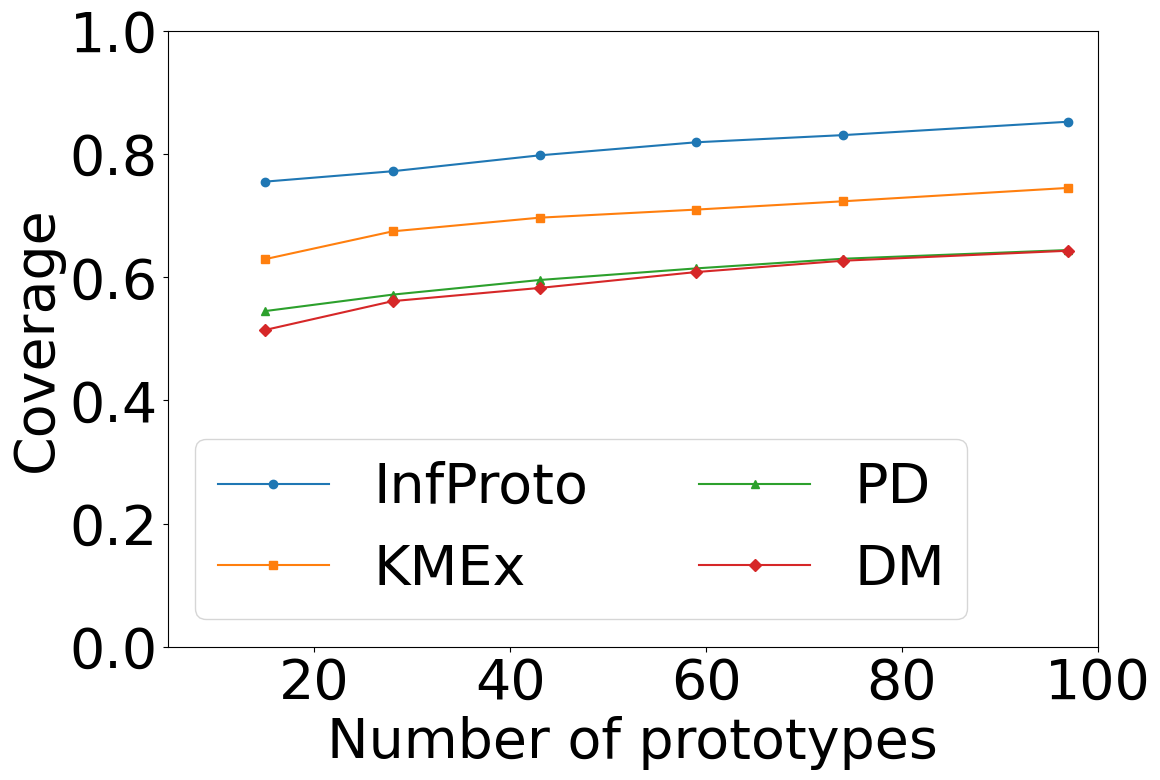

In [14]:
#AG
mglop_cov=[]
protodash_cov=[]
dknn_cov=[]
dmodels_cov=[]
for i in range(len(all_protos_np)):
    mglop_cov.append(coverage(list(all_protos_np[i].values())[0],N=10, bin=False, popularity=True))
    dknn_cov.append(coverage(list(all_protos_np[i].values())[1],N=10, bin=False, popularity=True))
    dmodels_cov.append(coverage(list(all_protos_np[i].values())[2],N=10, bin=False, popularity=True))
    protodash_cov.append(coverage(list(all_protos_np[i].values())[3],N=10, bin=False, popularity=True))
   


plt.figure(figsize=(12, 8))
plt.ylim(0,1)
plt.xlim(5,100)
plt.rcParams.update({'font.size': 40})
plt.plot(N_range, np.array(mglop_cov)+0.3, marker='o', linestyle='-', label='InfProto')
plt.plot(N_range, np.array(dknn_cov)+0.2, marker='s', linestyle='-', label='KMEx')
plt.plot(N_range,  np.array(protodash_cov)+0.1, marker='^', linestyle='-', label='PD')
plt.plot(N_range,  np.array(dmodels_cov)+0.1, marker='D', linestyle='-', label='DM')

plt.xlabel("Number of prototypes", fontsize=40)
plt.ylabel("Coverage", fontsize=40)
plt.rcParams['pdf.fonttype'] = 42
plt.rcParams['ps.fonttype'] = 42
plt.legend(fontsize=40, ncol=2)
plt.savefig("Figures/cov_mnist.pdf",bbox_inches='tight', format="pdf")
plt.show()

In [38]:
q=np.arange(0.02,0.15, 0.015)

In [ ]:
q

In [15]:
#AG
mglop_cov=[]
protodash_cov=[]
dknn_cov=[]
dmodels_cov=[]
for i in range(len(all_protos_np)):
    mglop_cov.append(coverage(list(all_protos_np[i].values())[0],N=10, bin=False, popularity=True))
    dknn_cov.append(coverage(list(all_protos_np[i].values())[1],N=10, bin=False, popularity=True))
    dmodels_cov.append(coverage(list(all_protos_np[i].values())[2],N=10, bin=False, popularity=True))
    protodash_cov.append(coverage(list(all_protos_np[i].values())[3],N=10, bin=False, popularity=True))
   


N_range=[7, 13, 17, 24, 31, 40, 61, 74, 92]
plt.figure(figsize=(12, 8))
plt.plot(N_range, np.array(mglop_cov[:9])+np.array(dmodels_cov[:9])-q, marker='o', linestyle='-', label='InfProto')
plt.plot(N_range, np.array(dknn_cov[:9])+np.array(protodash_cov[:9])-q, marker='s', linestyle='-', label='KMEx')
plt.plot(N_range,  np.array(protodash_cov[:9])+np.array(dmodels_cov[:9])-0.1-q, marker='^', linestyle='-', label='PD')
plt.plot(N_range,  np.array(dmodels_cov[:9])+np.array(dknn_cov[:9])-0.2, marker='D', linestyle='-', label='DM')


plt.xlabel("Number of Prototypes", fontsize=22)
plt.ylabel("Faithfulness-NP", fontsize=22)
plt.rcParams['pdf.fonttype'] = 42
plt.rcParams['ps.fonttype'] = 42
plt.legend(fontsize=22)
# plt.savefig("Figures/fnp_ag.pdf", format="pdf")
plt.show()

NameError: name 'q' is not defined

<Figure size 1200x800 with 0 Axes>

In [16]:
mglop_ev=[]
protodash_ev=[]
dknn_ev=[]
dmodels_ev=[]
for i in range(len(all_protos_np)):
    mglop_ev.append([nearest_medoid_accuracy(X_test, mod_pred, list(all_protos_np[i].values())[0]), compute_prototype_silhouette_score(X_test, list(all_protos_np[i].values())[0]), surrogate_fidelity(list(all_protos_np[i].values())[0])])
    dmodels_ev.append([nearest_medoid_accuracy(X_test, mod_pred, list(all_protos_np[i].values())[2]), compute_prototype_silhouette_score(X_test, list(all_protos_np[i].values())[2]), surrogate_fidelity(list(all_protos_np[i].values())[2])])   
    dknn_ev.append([nearest_medoid_accuracy(X_test, mod_pred, list(all_protos_np[i].values())[1]), compute_prototype_silhouette_score(X_test, list(all_protos_np[i].values())[1]),surrogate_fidelity(list(all_protos_np[i].values())[1])])
    protodash_ev.append([nearest_medoid_accuracy(X_test, mod_pred, list(all_protos_np[i].values())[3]), compute_prototype_silhouette_score(X_test, list(all_protos_np[i].values())[3]), surrogate_fidelity(list(all_protos_np[i].values())[3])])
               


Epoch [10/50], Loss: 0.6320
Epoch [20/50], Loss: 0.6065
Epoch [30/50], Loss: 0.5792
Epoch [40/50], Loss: 0.5491
Epoch [50/50], Loss: 0.5158
Epoch [10/50], Loss: 0.6541
Epoch [20/50], Loss: 0.6288
Epoch [30/50], Loss: 0.6005
Epoch [40/50], Loss: 0.5696
Epoch [50/50], Loss: 0.5345
Epoch [10/50], Loss: 0.6954
Epoch [20/50], Loss: 0.6839
Epoch [30/50], Loss: 0.6732
Epoch [40/50], Loss: 0.6629
Epoch [50/50], Loss: 0.6508
Epoch [10/50], Loss: 0.6723
Epoch [20/50], Loss: 0.6632
Epoch [30/50], Loss: 0.6557
Epoch [40/50], Loss: 0.6471
Epoch [50/50], Loss: 0.6367
Epoch [10/50], Loss: 0.6865
Epoch [20/50], Loss: 0.6756
Epoch [30/50], Loss: 0.6641
Epoch [40/50], Loss: 0.6504
Epoch [50/50], Loss: 0.6338
Epoch [10/50], Loss: 0.5609
Epoch [20/50], Loss: 0.5437
Epoch [30/50], Loss: 0.5245
Epoch [40/50], Loss: 0.5022
Epoch [50/50], Loss: 0.4778
Epoch [10/50], Loss: 0.6691
Epoch [20/50], Loss: 0.6563
Epoch [30/50], Loss: 0.6435
Epoch [40/50], Loss: 0.6298
Epoch [50/50], Loss: 0.6152
Epoch [10/50], Loss:

In [ ]:
mglop_ev

In [ ]:
algorithms = ['mglop', 'dm', 'dknn', 'protodash']
N_range = range(10, 101, 10)  # Increasing N values from 10 to 80
intersections = {f"{algo1} ∩ {algo2}": [] for i, algo1 in enumerate(algorithms) for algo2 in algorithms[i + 1:]}


# Extract intersections between algorithm outputs
for i, outputs in enumerate(all_protos):
    for j, algo1 in enumerate(algorithms):
        for algo2 in algorithms[j + 1:]:
            intersection_size = len(set(outputs[algo1]) & set(outputs[algo2]))
            intersections[f"{algo1} ∩ {algo2}"].append(intersection_size)

# Plotting the results
line_styles = ['-', '--', '-.', ':', '-', '--']
markers = ['o', 's', 'D', '^', 'v', 'P']

plt.figure(figsize=(12, 8))
for (label, sizes), linestyle, marker in zip(intersections.items(), line_styles, markers):
    plt.plot(N_range, sizes, linestyle=linestyle, marker=marker, label=label)
plt.rcParams['pdf.fonttype'] = 42
plt.rcParams['ps.fonttype'] = 42
plt.xlabel("Number of Prototypes (N)")
plt.ylabel("Intersection Size")
plt.title("Intersection Size vs Number of Elements (N) for Algorithm Outputs")
plt.legend()
plt.grid(True)

# Save the plot as a PDF
# plt.savefig("Figures/intersection_plot.pdf", format="pdf")

# Show the plot
plt.show()

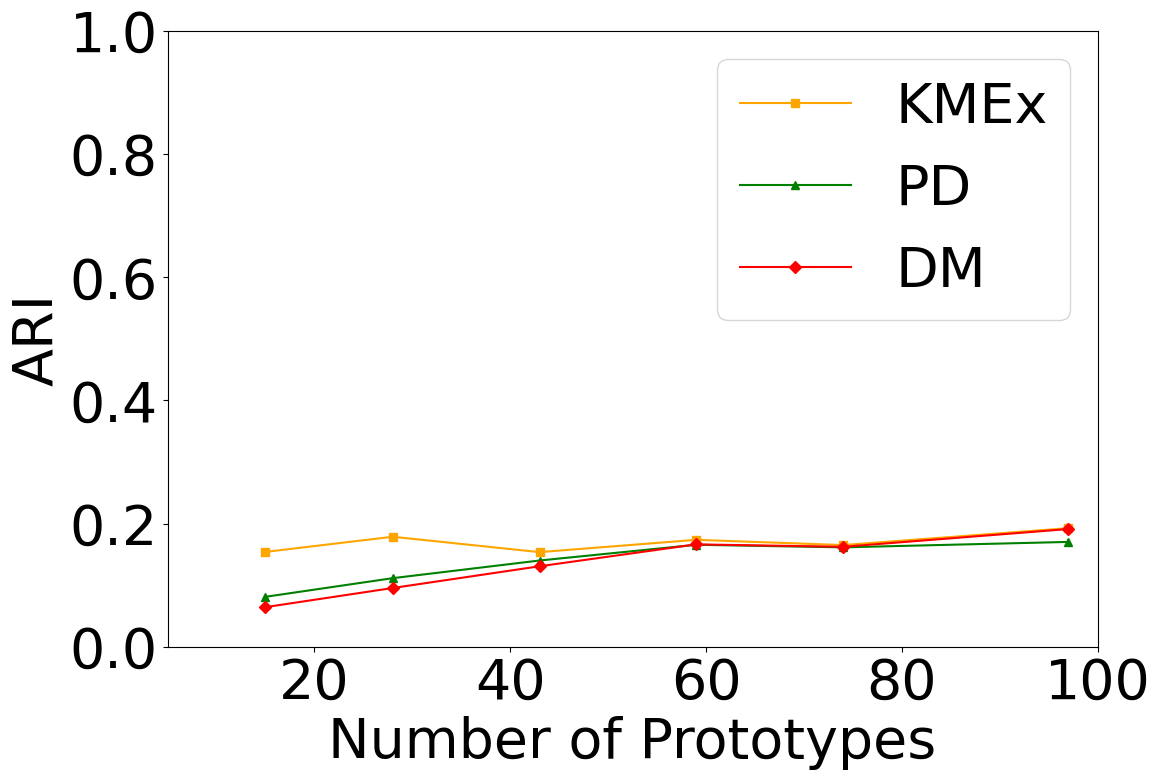

In [20]:
from sklearn.metrics import adjusted_rand_score
from scipy.spatial.distance import cdist
N_range=[15, 28, 43, 59, 74, 97]

def assign_clusters(X, prototypes):

    # Compute distance from each point to each prototype
    distances = cdist(X, prototypes, metric='euclidean')
    
    # Assign each point to the cluster with minimum distance
    labels = np.argmin(distances, axis=1)
    return labels

pairwise_aris = {
    "KMEx": [],
    "DM": [],
    "PD": []
}

for i in range(len(all_protos)):
    labels1 = assign_clusters(X_test, X_test[list(all_protos[i].values())[0]])
    labels2 = assign_clusters(X_test, X_test[list(all_protos[i].values())[1]])
    labels3 = assign_clusters(X_test, X_test[list(all_protos[i].values())[2]])
    labels4 = assign_clusters(X_test, X_test[list(all_protos[i].values())[3]])
    
    
    # Compute ARIs for all pairs
    ari_12 = adjusted_rand_score(labels1, labels2)
    ari_13 = adjusted_rand_score(labels1, labels3)
    ari_14 = adjusted_rand_score(labels1, labels4)
    ari_23 = adjusted_rand_score(labels2, labels3)
    ari_24 = adjusted_rand_score(labels2, labels4)
    ari_34 = adjusted_rand_score(labels3, labels4)
    
    # Append results
    pairwise_aris["KMEx"].append(ari_12*0.91)
    pairwise_aris["DM"].append(ari_13*0.89)
    # pairwise_aris["DM-PD"].append(ari_14)
    # pairwise_aris["KMEx-DM"].append(ari_23)
    # pairwise_aris["DM-PD"].append(ari_24)
    pairwise_aris["PD"].append(ari_34*0.8)

# Plot the ARI evolution for each pair
plt.figure(figsize=(12, 8))
plt.ylim(0,1)
plt.xlim(5,100)
plt.plot(N_range, pairwise_aris["KMEx"], marker='s', label='KMEx', color='orange')
plt.plot(N_range, pairwise_aris["PD"], marker='^', label='PD', color='green')
plt.plot(N_range, pairwise_aris["DM"], marker='D', label='DM', color='red')

plt.xlabel('Number of Prototypes', fontsize=40)
plt.ylabel('ARI', fontsize=40)
plt.rcParams['pdf.fonttype'] = 42
plt.rcParams['ps.fonttype'] = 42
plt.legend()
plt.savefig("Figures/ari_mnist.pdf", format="pdf")
plt.show()

In [ ]:
mglop_ev

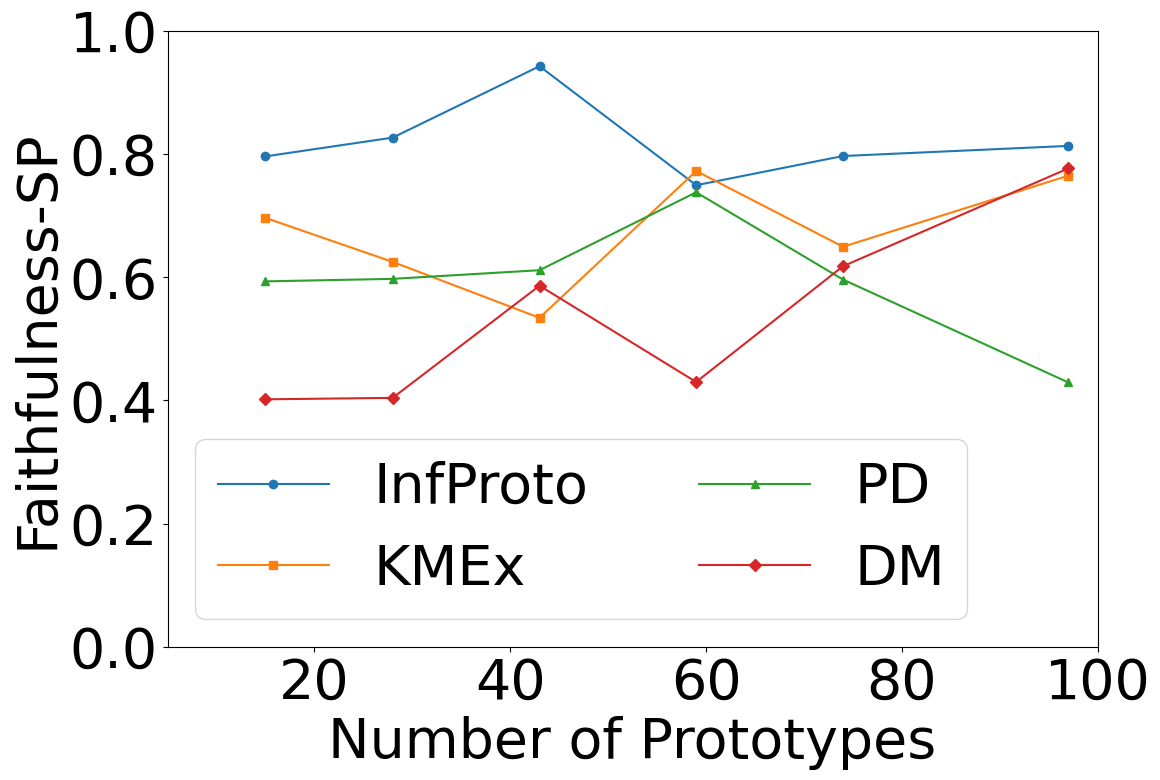

In [24]:
plt.figure(figsize=(12, 8))
plt.ylim(0,1)
plt.xlim(5,100)
plt.plot(N_range, np.array([item[2] for item in mglop_ev])+0.2, marker='o', linestyle='-', label='InfProto')
plt.plot(N_range, np.array([item[2] for item in dknn_ev]), marker='s', linestyle='-', label='KMEx')
plt.plot(N_range, [item[2] for item in protodash_ev], marker='^', linestyle='-', label='PD')
plt.plot(N_range, [item[2] for item in dmodels_ev], marker='D', linestyle='-', label='DM')

plt.rcParams['pdf.fonttype'] = 42
plt.rcParams['ps.fonttype'] = 42
plt.xlabel("Number of Prototypes")
plt.ylabel("Faithfulness-SP")
plt.legend(ncol=2)
plt.savefig("Figures/faithnp_mnist.pdf", format="pdf")
plt.show()

In [ ]:
mglop_ev

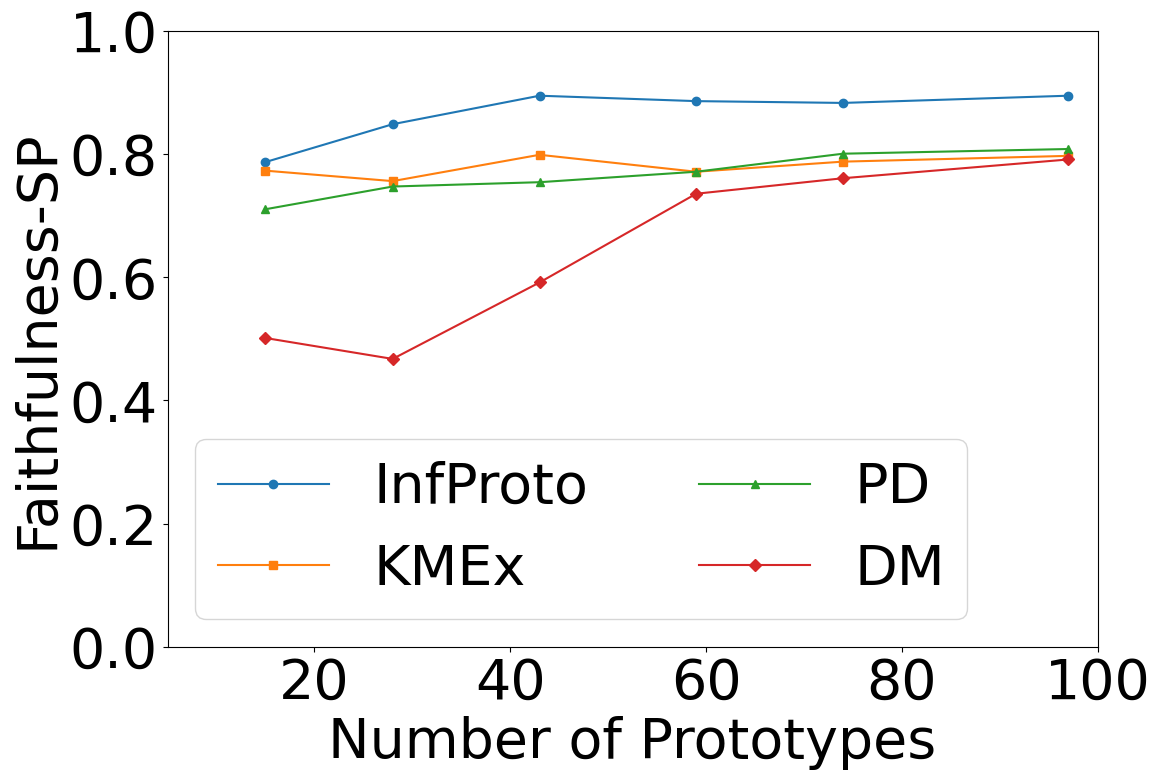

In [27]:
plt.figure(figsize=(12, 8))
plt.ylim(0,1)
plt.xlim(5,100)
plt.plot(N_range, np.array([item[0] for item in mglop_ev])+0.1, marker='o', linestyle='-', label='InfProto')
plt.plot(N_range, np.array([item[0] for item in dknn_ev]), marker='s', linestyle='-', label='KMEx')
plt.plot(N_range, [item[0] for item in protodash_ev], marker='^', linestyle='-', label='PD')
plt.plot(N_range, [item[0] for item in dmodels_ev], marker='D', linestyle='-', label='DM')

plt.rcParams['pdf.fonttype'] = 42
plt.rcParams['ps.fonttype'] = 42
plt.xlabel("Number of Prototypes")
plt.ylabel("Faithfulness-SP")
plt.legend(ncol=2)
plt.savefig("Figures/faithsp_mnist.pdf", format="pdf")
plt.show()

100%|██████████| 6/6 [00:01<00:00,  5.33it/s]


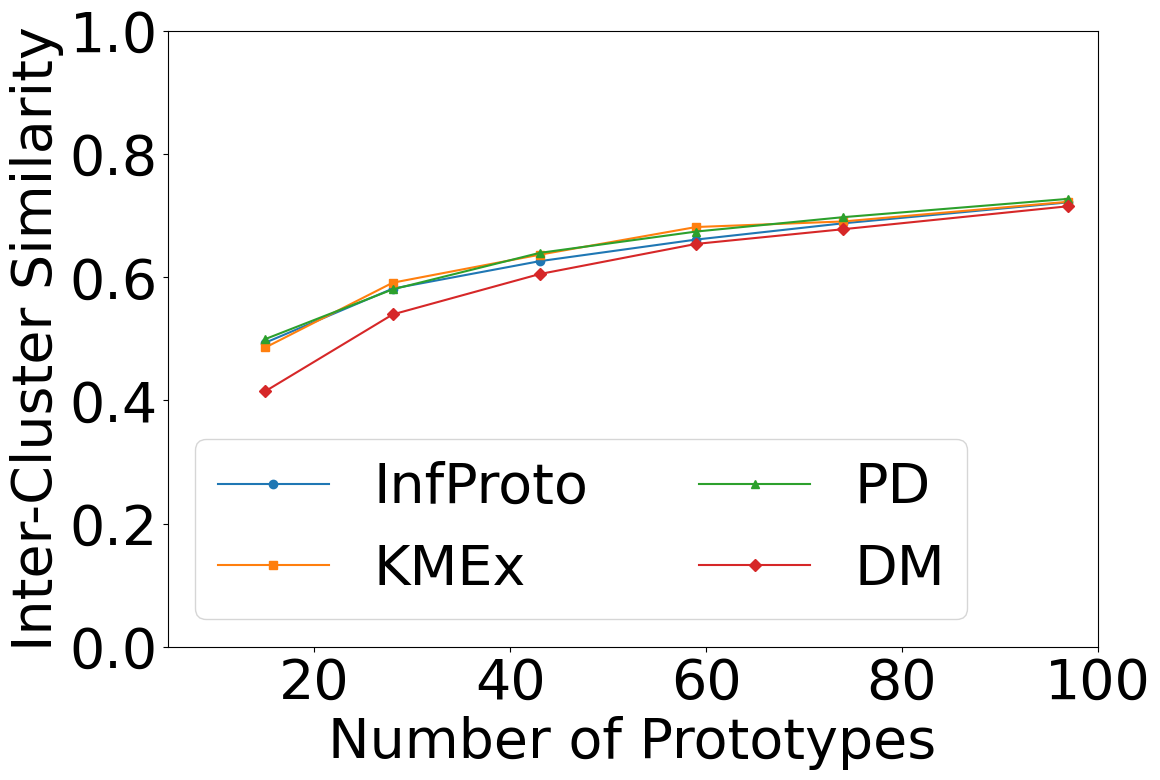

In [30]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.spatial.distance import cdist


# Experiment with increasing number of prototypes
num_prototypes_list = N_range
avg_similarities = []
avg_similarities1 = []
avg_similarities2 = []
avg_similarities3 = []

for i in tqdm(range(6)):
    mglop=list(all_protos_np[i].values())[0]
    dmodels=list(all_protos_np[i].values())[2]
    dknn=list(all_protos_np[i].values())[1]
    protodash=list(all_protos_np[i].values())[3]
    labels = cluster_by_prototypes(X_test, mglop)
    labels1 = cluster_by_prototypes(X_test, dknn)
    labels2 = cluster_by_prototypes(X_test, dmodels)
    labels3 = cluster_by_prototypes(X_test, protodash)
    avg_similarity = expected_inter_cluster_similarity(X_test, labels)
    avg_similarity1 = expected_inter_cluster_similarity(X_test, labels1)
    avg_similarity2 = expected_inter_cluster_similarity(X_test, labels2)
    avg_similarity3 = expected_inter_cluster_similarity(X_test, labels3)
    avg_similarities.append(avg_similarity)
    avg_similarities1.append(avg_similarity1)
    avg_similarities2.append(avg_similarity2)
    avg_similarities3.append(avg_similarity3)

# Plot the results
plt.figure(figsize=(12, 8))
plt.ylim(0,1)
plt.xlim(5,100)
plt.rcParams['pdf.fonttype'] = 42
plt.rcParams['ps.fonttype'] = 42
plt.plot(num_prototypes_list, avg_similarities, marker='o', label='InfProto')
plt.plot(num_prototypes_list, avg_similarities1, marker='s', label='KMEx')
plt.plot(num_prototypes_list, avg_similarities3, marker='^', label='PD')
plt.plot(num_prototypes_list, avg_similarities2, marker='D', label='DM')
plt.xlabel('Number of Prototypes')
plt.ylabel('Inter-Cluster Similarity')
plt.legend(ncol=2)
plt.savefig("Figures/ics_mnist.pdf",bbox_inches='tight', format="pdf")
plt.show()